In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from custom import noise, draw_graph
from statsmodels.regression.linear_model import OLS

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Introduction

This notebook serves to introduce the use of instrument variables, which can be used in **linear** models to figure out the effect of `x` on `y` in the absence of the ability to measure the known confounder.

Note: The method here was introduced to me via Jonas Peters' videos. I believe the assumption of linearity is a strong one: we must assume linear models, otherwise the math doesn't check out.

## Model

Assume we have the following model, specified via linear equations in NumPy code:

In [2]:
# Set up model with hidden coefficients (pretend that we know them for 
# now) and instrument variable.
size = 1000

gamma = 2
alpha = 3
beta = 5
delta = 0.2

h = noise(size)  # the hidden, unmeasured variable.
i = noise(size)  # the instrument variable
x = delta * i + beta * h + noise(size)
y = gamma * h + alpha * x + noise(size)

Graphically, this looks like the following:

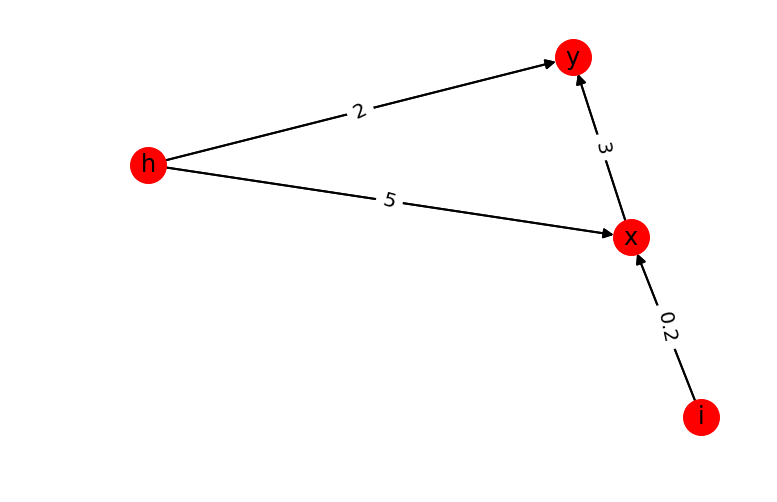

In [3]:
G = nx.DiGraph()
G.add_edge('x', 'y', coeff=alpha)
G.add_edge('h', 'y', coeff=gamma)
G.add_edge('h', 'x', coeff=beta)
G.add_edge('i', 'x', coeff=delta)

draw_graph(G)

If we were to regress $y$ directly on $x$, we would run into issues: Because we didn't measure the confounder variable $h$ (believe me for a moment that this is assumed to be true), our coefficients will be way off.

To show this, first, let's create the `pandas` DataFrame that will be used with `statsmodels`.

In [4]:
data = dict(x=x, i=i, h=h, y=y)
df = pd.DataFrame(data)

Now, we regress $y$ on $x$, and let's observe the output to see how good of a fit it is.

In [5]:
model = OLS.from_formula('y ~ x', data=df)
results = model.fit()
results.params

Intercept    0.057991
x            3.378959
dtype: float64

We're close, but not really there. (Remember, though, we wouldn't know this in a real-world scenario, where we might have postulated the presence of a hidden variable but didn't have the know-how to go out and measure it.)

In the real-world scenario above, we might want to see if there's an **instrument variable** to help us out with this problem.

The use of an instrumental variable works as such: We first regress the instrument variable $i$ on $x$, to obtain 'fitted' values of $\delta i$. We then regress $y$ on $\delta i$, which gives us the coefficient $alpha$.

Don't believe me? Look at the math below:

As a structured causal equation, the graphical model can be expressed as such:

$$y = \alpha x  + \delta h + n_{y}$$
$$x = \delta i + \beta h + n_{x}$$

where $n_{x}$ is the noise that generates uncertainty around $x$, and $n_{y}$ is the noise that generates uncertainty around $y$.

Substuting $x$ into the $y$ (don't take my word for it, try it yourself!), we get:

$$y = (\alpha \beta + \gamma) h + (\alpha) (\delta i) + \alpha n_{x} + n_{y}$$

The parentheses have been rearranged intentionally for the variable $i$. If we regress $x$ on $i$, we will get an estimate for the value of $\delta$. By then multiplying $\delta$ by $i$, we will get "fitted" values of $i$. We can then regress $y$ on $\delta i$ to get the value of $\alpha$, which is exactly what we want!

Enough in words, let's look at the code for this!

## Mechanics 

First, we regress $x$ on $i$.

In [6]:
model = OLS.from_formula('x ~ i', data=df)
results = model.fit()
results.params['i']

0.33487270349026976

Notice how we get an estimator that is kind of off (should be $0.2$). It isn't quite accurate, but my gut feeling tells me that's ok.

To create the fitted $i$, we multiply the learned regression parameter by the original values.

In [7]:
df['δi'] = df['i'] * results.params['i']

Then, we regress $y$ on $\delta i$:

In [8]:
model = OLS.from_formula('y ~ δi', data=df)
results = model.fit()
results.params

Intercept    0.178589
δi           3.087018
dtype: float64

Voila! We get back the effect of $x$ on $y$ by use of this instrument variable $i$! 

Really happy having seen that it works, and having seen some of the math that goes on behind it!

## Assumptions

Now, all of this sounds good and nice, but it does seem a bit "magical", to say the least. After all, "linearity" does seem like a very strong assumption. Moreover, in order to use an instrument variable, we have to justify that it has:

1. a causal effect on $x$,
2. no causal effect on $y$, and
3. no causal effect on $h$

Indeed, there is no free lunch here: we have to use background knowledge (or other means) to justify why $i$ is a suitable instrument variable; simply asserting this point is not sufficient.